In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns

In [152]:
df = pd.read_csv("android_bids_us.csv")

In [153]:
df.head()

,bidid,utc_time,app_id,user_state,user_isp,device_maker,device_model,device_osv,device_height,device_width,marketplace,click
0,87b0108c-6e9f-4783-8b80-8dd5aa3529a8,1536444331894,com.OppanaGames.CarSim,TX,AT&T Wireless,NaN,NaN,7.0,720,1280,chartboost,0
1,9284441f-a6ea-4698-9017-86436b92d416,1536444363932,com.mobilityware.CrownSolitaire,TX,T-Mobile USA,NaN,NaN,7.0,1280,720,chartboost,0
2,7e4779c2-f757-4324-8c2a-138b558b5a54,1536444386908,com.kuttigames.tenkyurollball,LA,AT&T Wireless,NaN,NaN,7.1.1,720,1280,chartboost,0
3,b64ea208-38ca-42ac-895e-0842d7352cc3,1536444405023,com.trendactionfree.call_of_sniper_duty_frontl...,TN,Comcast Cable,NaN,NaN,6.0.1,720,1280,chartboost,0
4,fd0c07cb-31f6-408c-9315-1cb652e76abc,1536444443458,com.landslab.my3rdgrademathgames,NC,AT&T U-verse,NaN,NaN,7.1.1,1024,768,chartboost,0


In [154]:
df.describe()

,utc_time,device_height,device_width,click
count,3.148828e+06,3.148828e+06,3.148828e+06,3.148828e+06
mean,1.538334e+12,1.180970e+03,1.152078e+03,6.770741e-02
std,2.320255e+09,5.190901e+02,4.526602e+02,2.512432e-01
min,1.533578e+12,1.400000e+01,1.400000e+01,0.000000e+00
25%,1.536460e+12,7.200000e+02,7.200000e+02,0.000000e+00
50%,1.538472e+12,1.080000e+03,1.080000e+03,0.000000e+00
75%,1.540095e+12,1.280000e+03,1.280000e+03,0.000000e+00
max,1.542630e+12,3.120000e+03,3.120000e+03,1.000000e+00


In [116]:
df.isna().sum()

bidid                 0
utc_time              0
app_id                0
user_state            0
user_isp             39
device_maker     964004
device_model     963858
device_osv            0
device_height         0
device_width          0
marketplace           0
click                 0
dtype: int64

In [117]:
df["user_state"].unique()

array(['TX', 'LA', 'TN', 'NC', 'FL', 'GA', 'ME', 'UT', 'OH', 'MN', 'IL',
       'WA', 'IN', 'MO', 'ID', 'VA', 'NJ', 'AZ', 'RI', 'DC', 'CA', 'WI',
       'AL', 'MS', 'CT', 'MD', 'NY', 'PA', 'MI', 'CO', 'MA', 'ND', 'KY',
       'WY', 'IA', 'DE', 'AR', 'OK', 'KS', 'SC', 'NM', 'HI', 'NH', 'NV',
       'AK', 'MT', 'SD', 'NE', 'OR', 'WV', 'VT'], dtype=object)

In [118]:
df["app_id"].unique()

array(['com.OppanaGames.CarSim', 'com.mobilityware.CrownSolitaire',
       'com.kuttigames.tenkyurollball', ...,
       'air.com.pixelstudio8.snake.io', 'com.te.highschool.girl',
       'com.casino.party.slots.my.lucky.vegas.free.slots777.games'],
      dtype=object)

In [119]:
df.columns

Index(['bidid', 'utc_time', 'app_id', 'user_state', 'user_isp', 'device_maker',
       'device_model', 'device_osv', 'device_height', 'device_width',
       'marketplace', 'click'],
      dtype='object')

We can group the features by categories: 
* Target feature: click
* Specific app features: app_id (and app_category if we could extract it)
* device features: device_maker, device_model, device_osv, device_height, device_width -> as a simplification, we could generally calculate a certain fingerprint of a device
* time, region specific features: utc_time, year, month, day, hour, is_weekend, is_working_day, region, timezone
* other: isp, marketplace and so on

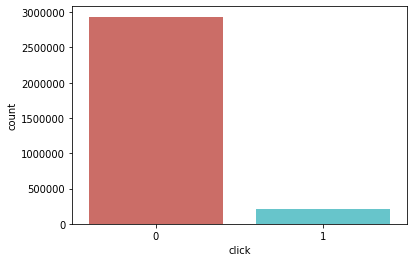

0    0.932293
1    0.067707
Name: click, dtype: float64

In [120]:
sns.countplot(x='click',data=df, palette='hls')
plt.show();
df['click'].value_counts()/len(df)

#### let's get other features

In [121]:
utc_time_str = df['utc_time'].astype('str')
df['timestamp'] = utc_time_str.apply(lambda r: pd.to_datetime("1970-01-01") + pd.Timedelta(r + 'milliseconds'))
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
df['is_working_day'] = (df['day_of_week'] < 5).astype('int')

In [122]:
# df['device_orientation'] = df.apply(lambda row: str(row['device_height'])+'x'+str(row['device_width']), axis=1)
df['device_fingerprint'] = df.apply(lambda row: str(row['device_maker'])+"$"+str(row["device_model"])+"$"+str(row["device_osv"])+"$"+str(row['device_height'])+'x'+str(row['device_width']), axis=1)
fingerprints = set(df['device_fingerprint'].unique())
fingerprints = dict(zip(fingerprints, range(len(fingerprints))))
df['device_fingerprint'] = df.apply(lambda row: fingerprints.get(row['device_fingerprint']), axis=1)
df.head(2)

,bidid,utc_time,app_id,user_state,user_isp,device_maker,device_model,device_osv,device_height,device_width,marketplace,click,timestamp,day_of_week,hour,month,year,is_working_day,device_fingerprint
0,87b0108c-6e9f-4783-8b80-8dd5aa3529a8,1536444331894,com.OppanaGames.CarSim,TX,AT&T Wireless,NaN,NaN,7.0,720,1280,chartboost,0,2018-09-08 22:05:31.894,5,22,9,2018,0,9124
1,9284441f-a6ea-4698-9017-86436b92d416,1536444363932,com.mobilityware.CrownSolitaire,TX,T-Mobile USA,NaN,NaN,7.0,1280,720,chartboost,0,2018-09-08 22:06:03.932,5,22,9,2018,0,1517


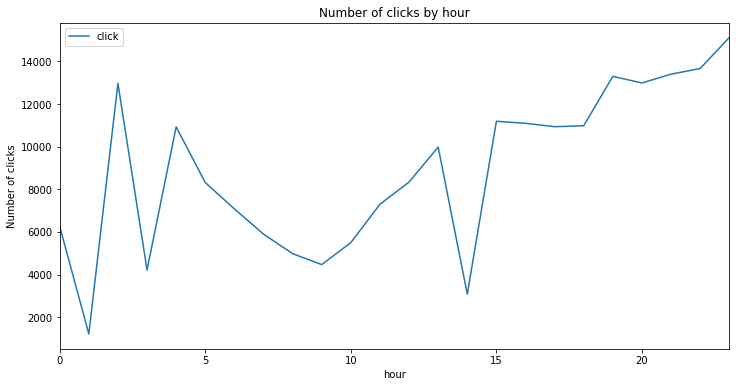

In [123]:
df.groupby('hour').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour');

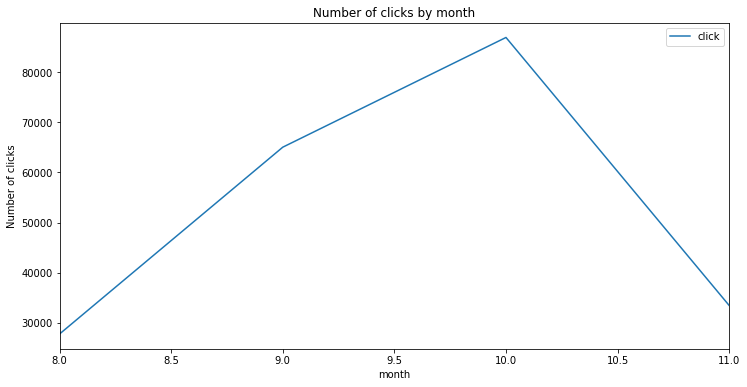

In [124]:
df.groupby('month').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by month');

good  point for dividing data by month

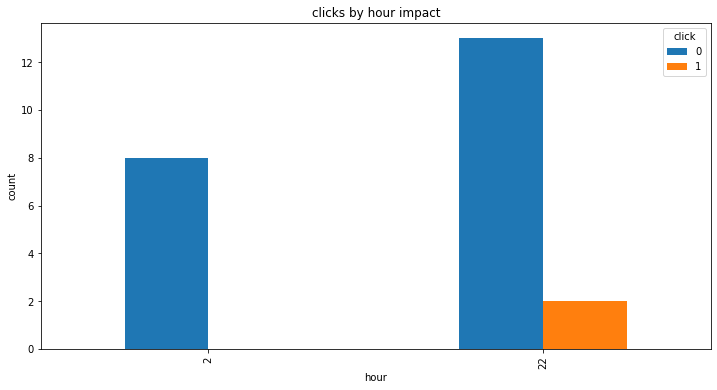

In [125]:
train.groupby(['hour', 'click']).size().unstack().plot(kind='bar', title="Hour", figsize=(12,6))
plt.ylabel('count')
plt.title('clicks by hour impact');

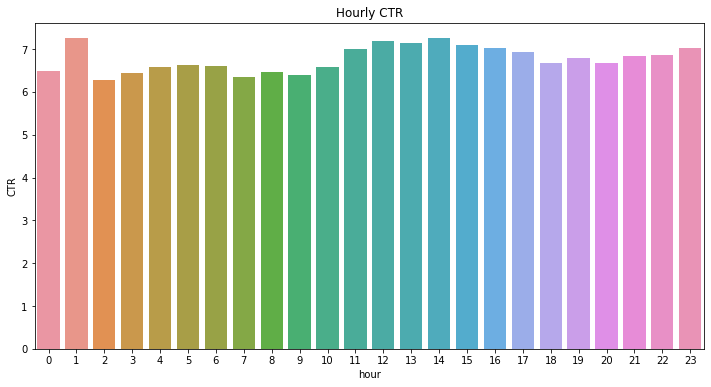

In [127]:
df_click = df[df['click'] == 1]
df_hour = df[['hour','click']].groupby(['hour']).count().reset_index()
df_hour = df_hour.rename(columns={'click': 'impressions'})
df_hour['clicks'] = df_click[['hour','click']].groupby(['hour']).count().reset_index()['click']
df_hour['CTR'] = df_hour['clicks']/df_hour['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='hour', data=df_hour)
plt.title('Hourly CTR');

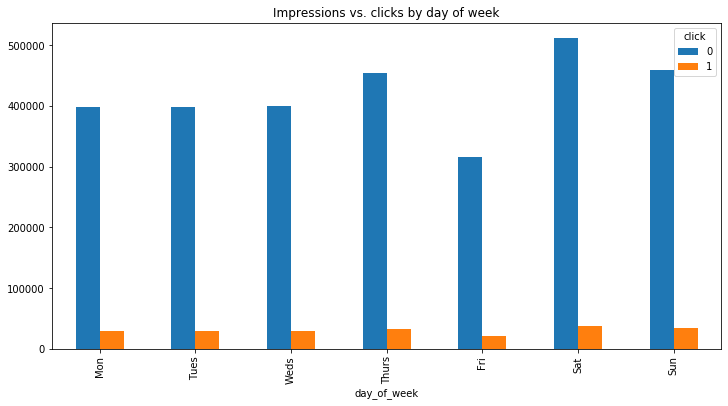

In [133]:
ticks = list(range(0, 7, 1))
df.groupby(['day_of_week','click']).size().unstack().reindex(ticks).plot(kind='bar', title="Day of the Week", figsize=(12,6))
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('Impressions vs. clicks by day of week');

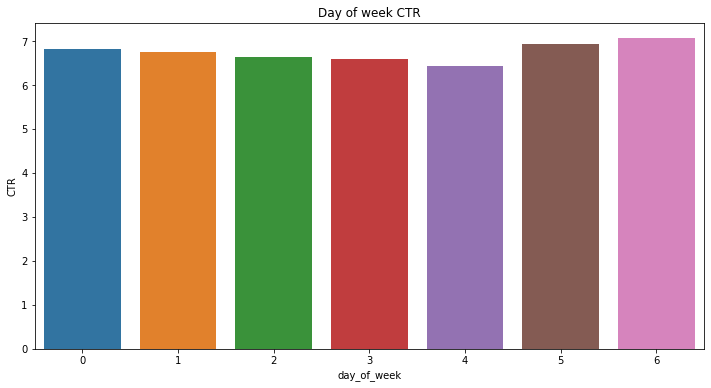

In [136]:
df_click = df[df['click'] == 1]
df_dayofweek = df[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'click': 'impressions'})
df_dayofweek['clicks'] = df_click[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()['click']
df_dayofweek['CTR'] = df_dayofweek['clicks']/df_dayofweek['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='day_of_week', data=df_dayofweek, order=list(range(0, 7, 1)))
plt.title('Day of week CTR');

In [139]:
len(df.device_fingerprint.unique())

10595

#### as we see It was bad idea to create device_fingerprint, it's kinda unique

In [142]:
cols = ["device_fingerprint"]
cols = [c for c in cols if c in df.index]
df = df.drop(cols, axis=1)

In [143]:
df.groupby(['user_state']).mean()["click"].nlargest(5)  

user_state
DE    0.075269
NM    0.072388
RI    0.072098
ND    0.071902
AZ    0.071862
Name: click, dtype: float64

In [145]:
df.groupby('user_state')['click'].describe()

,count,mean,std,min,25%,50%,75%,max
user_state,,,,,,,,
AK,3144.0,0.045165,0.207700,0.0,0.0,0.0,0.0,1.0
AL,47200.0,0.067691,0.251217,0.0,0.0,0.0,0.0,1.0
AR,18762.0,0.067583,0.251036,0.0,0.0,0.0,0.0,1.0
AZ,53728.0,0.071862,0.258262,0.0,0.0,0.0,0.0,1.0
CA,394602.0,0.070063,0.255253,0.0,0.0,0.0,0.0,1.0
CO,44615.0,0.064956,0.246450,0.0,0.0,0.0,0.0,1.0
CT,13267.0,0.065049,0.246621,0.0,0.0,0.0,0.0,1.0
DC,26902.0,0.065534,0.247471,0.0,0.0,0.0,0.0,1.0
DE,4185.0,0.075269,0.263856,0.0,0.0,0.0,0.0,1.0


In [146]:
df

,bidid,utc_time,app_id,user_state,user_isp,device_maker,device_model,device_osv,device_height,device_width,marketplace,click,timestamp,day_of_week,hour,month,year,is_working_day,device_fingerprint
0,87b0108c-6e9f-4783-8b80-8dd5aa3529a8,1536444331894,com.OppanaGames.CarSim,TX,AT&T Wireless,NaN,NaN,7.0,720,1280,chartboost,0,2018-09-08 22:05:31.894,5,22,9,2018,0,9124
1,9284441f-a6ea-4698-9017-86436b92d416,1536444363932,com.mobilityware.CrownSolitaire,TX,T-Mobile USA,NaN,NaN,7.0,1280,720,chartboost,0,2018-09-08 22:06:03.932,5,22,9,2018,0,1517
2,7e4779c2-f757-4324-8c2a-138b558b5a54,1536444386908,com.kuttigames.tenkyurollball,LA,AT&T Wireless,NaN,NaN,7.1.1,720,1280,chartboost,0,2018-09-08 22:06:26.908,5,22,9,2018,0,9197
3,b64ea208-38ca-42ac-895e-0842d7352cc3,1536444405023,com.trendactionfree.call_of_sniper_duty_frontl...,TN,Comcast Cable,NaN,NaN,6.0.1,720,1280,chartboost,0,2018-09-08 22:06:45.023,5,22,9,2018,0,7527
4,fd0c07cb-31f6-408c-9315-1cb652e76abc,1536444443458,com.landslab.my3rdgrademathgames,NC,AT&T U-verse,NaN,NaN,7.1.1,1024,768,chartboost,0,2018-09-08 22:07:23.458,5,22,9,2018,0,6151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148823,a38d5eba-ad93-430e-8323-dd8ea0d713a2,1541472458853,com.altitude.rrsv,TX,T-Mobile USA,Samsung,SM-J327T1,7.0,720,1280,chartboost,0,2018-11-06 02:47:38.853,1,2,11,2018,1,7184
3148824,f4cb0a53-c02c-43a2-9d44-fcd79f18127e,1541472485093,com.slots.realvegas,GA,Mediacom Cable,NaN,NaN,8.1.0,1920,1080,chartboost,0,2018-11-06 02:48:05.093,1,2,11,2018,1,5451
3148825,6c9a06ab-29ac-445d-b4e0-e7ebe66ce2b1,1541472516760,br.com.tapps.penguinevolution,MO,Sprint PCS,LG,SP200,7.1.2,1280,720,chartboost,0,2018-11-06 02:48:36.760,1,2,11,2018,1,8372
3148826,df975817-8218-4709-a9c0-e1d56c4a63b4,1541472552347,air.com.FDGEntertainment.Lonewolf.gp,WI,Spectrum,Motorola,Moto G Plus (5th Gen.),7.0,1080,1920,chartboost,0,2018-11-06 02:49:12.347,1,2,11,2018,1,6527


In [147]:
df['device_orientation'].unique()

KeyError: 'device_orientation'

In [148]:
df = pd.concat([df, pd.get_dummies(df['device_orientation'], prefix='orient')], axis=1)
cols = ['user_isp','device_maker','device_model', 'device_height', 'device_width', 'app_id', 'marketplace']
cols = [c for c in cols if c in df.index]
df = df.drop(cols, axis=1)

KeyError: 'device_orientation'

In [150]:
df

,bidid,utc_time,app_id,user_state,user_isp,device_maker,device_model,device_osv,device_height,device_width,marketplace,click,timestamp,day_of_week,hour,month,year,is_working_day,device_fingerprint
0,87b0108c-6e9f-4783-8b80-8dd5aa3529a8,1536444331894,com.OppanaGames.CarSim,TX,AT&T Wireless,NaN,NaN,7.0,720,1280,chartboost,0,2018-09-08 22:05:31.894,5,22,9,2018,0,9124
1,9284441f-a6ea-4698-9017-86436b92d416,1536444363932,com.mobilityware.CrownSolitaire,TX,T-Mobile USA,NaN,NaN,7.0,1280,720,chartboost,0,2018-09-08 22:06:03.932,5,22,9,2018,0,1517
2,7e4779c2-f757-4324-8c2a-138b558b5a54,1536444386908,com.kuttigames.tenkyurollball,LA,AT&T Wireless,NaN,NaN,7.1.1,720,1280,chartboost,0,2018-09-08 22:06:26.908,5,22,9,2018,0,9197
3,b64ea208-38ca-42ac-895e-0842d7352cc3,1536444405023,com.trendactionfree.call_of_sniper_duty_frontl...,TN,Comcast Cable,NaN,NaN,6.0.1,720,1280,chartboost,0,2018-09-08 22:06:45.023,5,22,9,2018,0,7527
4,fd0c07cb-31f6-408c-9315-1cb652e76abc,1536444443458,com.landslab.my3rdgrademathgames,NC,AT&T U-verse,NaN,NaN,7.1.1,1024,768,chartboost,0,2018-09-08 22:07:23.458,5,22,9,2018,0,6151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148823,a38d5eba-ad93-430e-8323-dd8ea0d713a2,1541472458853,com.altitude.rrsv,TX,T-Mobile USA,Samsung,SM-J327T1,7.0,720,1280,chartboost,0,2018-11-06 02:47:38.853,1,2,11,2018,1,7184
3148824,f4cb0a53-c02c-43a2-9d44-fcd79f18127e,1541472485093,com.slots.realvegas,GA,Mediacom Cable,NaN,NaN,8.1.0,1920,1080,chartboost,0,2018-11-06 02:48:05.093,1,2,11,2018,1,5451
3148825,6c9a06ab-29ac-445d-b4e0-e7ebe66ce2b1,1541472516760,br.com.tapps.penguinevolution,MO,Sprint PCS,LG,SP200,7.1.2,1280,720,chartboost,0,2018-11-06 02:48:36.760,1,2,11,2018,1,8372
3148826,df975817-8218-4709-a9c0-e1d56c4a63b4,1541472552347,air.com.FDGEntertainment.Lonewolf.gp,WI,Spectrum,Motorola,Moto G Plus (5th Gen.),7.0,1080,1920,chartboost,0,2018-11-06 02:49:12.347,1,2,11,2018,1,6527


In [60]:
pd.pivot_table(df, index=['is_working_day'], values='click', aggfunc='mean')


,click
is_working_day,
0,0.121212


In [62]:
pd.pivot_table(df, index=['month'], values='click', aggfunc='mean')

,click
month,
9,0.121212


### logistic regression model

In [65]:
df_random_order = df.sample(len(df)).reset_index()
total_rows = len(df_random_order)
cutoff_percentage = int(len(df_random_order) * .70)
train = df_random_order.iloc[:cutoff_percentage, :]
test = df_random_order.iloc[cutoff_percentage:, :]
df.columns

Index(['bidid', 'utc_time', 'app_id', 'user_state', 'user_isp', 'device_maker',
       'device_model', 'device_osv', 'device_height', 'device_width',
       'marketplace', 'click', 'timestamp', 'day_of_week', 'hour', 'month',
       'year', 'is_working_day', 'device_orientation', 'orient_1024x768',
       'orient_1080x1920', 'orient_1280x720', 'orient_1440x2672',
       'orient_1920x1080', 'orient_480x854', 'orient_720x1280',
       'orient_918x1887'],
      dtype='object')

In [69]:
from sklearn.linear_model import LogisticRegression

logit_model = LogisticRegression(class_weight = 'balanced')

x_cols = ['month', 'orient_1024x768',
       'orient_1080x1920', 'orient_1280x720', 'orient_1440x2672',
       'orient_1920x1080', 'orient_480x854', 'orient_720x1280',
       'orient_918x1887', 'is_working_day']
y = 'click'

logit_model.fit(train[x_cols], train[y])
pd.DataFrame(logit_model.coef_, columns = [x_cols])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,month,orient_1024x768,orient_1080x1920,orient_1280x720,orient_1440x2672,orient_1920x1080,orient_480x854,orient_720x1280,orient_918x1887,is_working_day
0,-0.049736,1.49716,-0.467821,0.902483,0.0,-0.57645,-0.340939,-0.831142,-0.188816,0.0


In [70]:
predictions = logit_model.predict(train[x_cols])
train['predictions'] = predictions
train['predictions'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    17
1     6
Name: predictions, dtype: int64

In [72]:
predicted_probs = logit_model.predict_proba(train[x_cols])
predicted_probs

array([[0.78317895, 0.21682105],
       [0.38951873, 0.61048127],
       [0.65519697, 0.34480303],
       [0.78317895, 0.21682105],
       [0.78317895, 0.21682105],
       [0.38951873, 0.61048127],
       [0.78317895, 0.21682105],
       [0.73683777, 0.26316223],
       [0.38951873, 0.61048127],
       [0.78317895, 0.21682105],
       [0.73683777, 0.26316223],
       [0.73683777, 0.26316223],
       [0.38951873, 0.61048127],
       [0.7152393 , 0.2847607 ],
       [0.7152393 , 0.2847607 ],
       [0.68870803, 0.31129197],
       [0.7152393 , 0.2847607 ],
       [0.26037643, 0.73962357],
       [0.78317895, 0.21682105],
       [0.78317895, 0.21682105],
       [0.73683777, 0.26316223],
       [0.68870803, 0.31129197],
       [0.38951873, 0.61048127]])

In [73]:
predictions = logit_model.predict(test[x_cols])
test['predictions'] = predictions
test['predictions'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    7
1    3
Name: predictions, dtype: int64